In [1]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sb
import pickle as pkl
from braindecode.datasets import BaseConcatDataset, create_from_X_y
from shutil import copyfile
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from data_util import load_subjects, load_subject_data, load_data, euclidean_alignment, label_alignment
from alignment import np_compute_transform_mat, np_euclidean_alignment, np_compute_target_transform_mats, np_label_alignment
from util import np_standardize

In [2]:
# data_dir = "/content/drive/MyDrive/DataVIN/Official"
# als_data_dir = "/content/drive/MyDrive/VIN_ALS"
data_dir = "../data/vin/Official"
als_data_dir = "../data/vin/Official"

In [91]:
%%time
# fmt: off
# subjects = [
#     'K300', 'K309', 'K310', 'K311', 'K312', 
#     'K313', 'K314', 'K315', 'K316', 'K319', 
#     'K320', 'K321', 'K322', 'K323', 'K324', 
#     'K325', 'K326', 'K327', 'K328', 'K329', 
#     'K330', 'K331', 'K332', 'K333', 'K334', 
#     'K335', 'K336', 'K337', 'K338', 'K339', 
#     'K340', 'K342', 'K343', 'K344', 'K350', 
#     'K351', 'K352', 'K353', 'K354', 'K355', 
#     'K356', 'K357', 'K358', 'K359', 'K360', 
#     'K361', 'K362', 'K363', 'K364', 'K365', 
#     'K366', 'K367', 'K368', 'K369', 'K370', 
#     'K371', 'K372', 'K373', 'K374', 'K375',
# ]

subjects = [
    'K001', 'K002', 'K003', 'K004',
    'K005', 'K006', 'K007', 'K008', 'K009',
    'K010', 'K011', 'K012', 'K013', 'K014',
    'K015', 'K016', 'K017', 'K018', 'K019',
    'K020', 'K021', 'K022', 'K023', 'K024',
    'K025', 'K026', 'K027', 'K028', 'K299',
    'K300', 'K301', 'K302', 'K303', 'K304',
    'K305', 'K306', 'K307', 'K308', 'K309',
    'K310', 'K311', 'K312', 'K313', 'K314',
    'K315', 'K316', 'K317', 'K319',
    'K320', 'K321', 'K322', 'K323', 'K324',
    'K325', 'K326', 'K327', 'K328', 'K329',
    'K330', 'K331', 'K332', 'K333', 'K334',
    'K335', 'K336', 'K337', 'K338', 'K339',
    'K340', 'K342', 'K343', 'K344', 'K350',
    'K351', 'K352', 'K353', 'K354', 'K355',
    'K356', 'K357', 'K358', 'K359', 'K360',
    'K361', 'K362', 'K363', 'K364', 'K365',
    'K366', 'K367', 'K368', 'K369', 'K370',
    'K371', 'K372', 'K373', 'K374', 'K375',
]

subjects = sorted(subjects)

scenarios = [
    "nâng tay trái",
    "nâng tay phải",
    "nâng chân trái",
    "nâng chân phải",
    # "gật đầu",
    # "lắc đầu",
    # "há miệng",
]

events = [
    "Thinking",
    # "Thinking and Acting",
    "Resting",
    # "Typing",
]

channels = [
    # "Fp1", "Fp2",
    # "F7", "F3", "Fz", "F4", "F8",
    # "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
    "FC5", "FC1", "FC2", "FC6",
    "T7", "C3", "Cz", "C4", "T8",
    # "C3", "Cz", "C4",
    "CP5", "CP1", "CP2", "CP6",
    # "P7", "P3", "Pz", "P4", "P8",
    # "PO9", "O1", "Oz", "O2", "PO10",
    # "O1", "Oz", "O2",
]
# channels = [
#     # "F3", "Fz", "F4",
#     "FC5", "FC1", "FC2", "FC6",
#     "C3", "Cz", "C4",
#     "CP5", "CP1", "CP2", "CP6",
#     # "P3", "Pz", "P4",
# ]

label_mapping={
    "nâng tay trái_Thinking": "nâng tay trái",
    "nâng tay phải_Thinking": "nâng tay phải",
    # "nâng tay trái_Thinking": "nâng tay",
    # "nâng tay phải_Thinking": "nâng tay",
    # "nâng tay trái_Thinking": "mi",
    # "nâng tay phải_Thinking": "mi",
    "nâng chân trái_Thinking": "nâng chân trái",
    "nâng chân phải_Thinking": "nâng chân phải",
    # "nâng chân trái_Thinking": "nâng chân",
    # "nâng chân phải_Thinking": "nâng chân",
    # "nâng chân trái_Thinking": "mi",
    # "nâng chân phải_Thinking": "mi",
    "gật đầu_Thinking": "gật đầu",
    "lắc đầu_Thinking": "lắc đầu",
    # "gật đầu_Thinking": "đầu",
    # "lắc đầu_Thinking": "đầu",
    # "gật đầu_Thinking": "mi",
    # "lắc đầu_Thinking": "mi",
    "há miệng_Thinking": "há miệng",
    # "há miệng_Thinking": "mi",
    "nâng tay trái_Thinking and Acting": "nâng tay trái",
    "nâng tay phải_Thinking and Acting": "nâng tay phải",
    "nâng chân trái_Thinking and Acting": "nâng chân trái",
    "nâng chân phải_Thinking and Acting": "nâng chân phải",
    "gật đầu_Thinking and Acting": "gật đầu",
    "lắc đầu_Thinking and Acting": "lắc đầu",
    "há miệng_Thinking and Acting": "há miệng",
    "Resting": "rest",
}

n_channels = len(channels)

print(f"using {n_channels} channels")

minimal_trial_duration = 3  # @param
window_duration = 2  # @param
window_stride_duration = 0.5  # @param

fmin = 8.0  # @param
fmax = 30.0  # @param

ds = load_data(
    data_dir,  
    subjects=subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=False,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

# als_subjects = ["ALS01_t1", "ALS01_t2", "ALS02_t1", "ALS02_t2"]

# als_ds = load_data(
#     als_data_dir,  
#     subjects=als_subjects,
#     scenarios=scenarios,
#     events=events,
#     channels=channels,
#     label_mapping=label_mapping,
#     minimal_trial_duration=minimal_trial_duration,
#     window_duration=window_duration, 
#     window_stride_duration=window_stride_duration, 
#     start_offset=0,
#     stop_offset=0,
#     fmin=fmin, 
#     fmax=fmax, 
#     moving_standardize=False,
#     resample=None,
#     return_raw=False,
#     return_preprocessed=False,
#     preload=True,
# )

# ds = BaseConcatDataset([ds, als_ds])

# fmt: on

# for _ds in ds.datasets:
#     _ds_info = _ds.description
#     if _ds_info["subject"] == "K314":
#         _ds_info["subject"] = "K314_t1"
#     elif _ds_info["subject"] == "K324":
#         _ds_info["subject"] = "K314_t2"

ds_info = ds.description

ds_info["epochs"] = 0
for i, r in ds_info.iterrows():
    ds_info.loc[i, "epochs"] = len(ds.datasets[i].windows)

print(f"loaded {len(ds_info['subject'].unique())} subjects - {ds_info['epochs'].sum()} epochs")
ds_info

using 13 channels


subject:  12%|█▏        | 13/109 [00:00<00:01, 91.43it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  27%|██▋       | 29/109 [00:00<00:02, 28.82it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.i

loaded 96 subjects - 24621 epochs
CPU times: user 56.8 s, sys: 4.87 s, total: 1min 1s
Wall time: 1min 4s


,subject,scenario,event,label,trial,split,epochs
0,K001,nâng tay trái,Thinking,nâng tay trái,0,train,9
1,K001,nâng tay trái,Resting,rest,0,train,10
2,K001,nâng tay trái,Resting,rest,1,train,5
3,K001,nâng tay trái,Thinking,nâng tay trái,1,train,10
4,K001,nâng tay trái,Resting,rest,2,train,4
...,...,...,...,...,...,...,...
2713,K375,nâng chân phải,Resting,rest,2,train,4
2714,K375,nâng chân phải,Resting,rest,3,train,5
2715,K375,nâng chân phải,Thinking,nâng chân phải,2,train,11
2716,K375,nâng chân phải,Resting,rest,4,train,6


In [65]:
ds_info[(ds_info["subject"] == "K300") & (ds_info["label"] == "nâng tay trái")]

,subject,scenario,event,label,trial,split,epochs
490,K300,nâng tay trái,Thinking,nâng tay trái,0,train,10
493,K300,nâng tay trái,Thinking,nâng tay trái,1,train,27
496,K300,nâng tay trái,Thinking,nâng tay trái,2,train,11


In [66]:
ds.datasets[0].windows.event_id

{'rest': 0,
 'nâng chân phải': 1,
 'nâng chân trái': 2,
 'nâng tay phải': 3,
 'nâng tay trái': 4}

In [5]:
import numpy as np
from scipy import linalg, stats, signal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import mne
# import yasa
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier
from pyriemann.estimation import Covariances
# from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import TSclassifier, MDM, FgMDM
import pickle as pkl
from tqdm import tqdm
from copy import deepcopy
from collections import defaultdict

In [10]:
ds_ea = deepcopy(ds)
euclidean_alignment(ds_ea, target_subject=None, labeled_trials=None)

subject: 100%|██████████| 97/97 [00:05<00:00, 16.39it/s]


In [92]:
train_trials = {
    "rest": [0, 1],
    "nâng chân trái": [0],
    "nâng chân phải": [0],
    "nâng tay trái": [0],
    "nâng tay phải": [0],
}

# valid_trials = {
#     "rest": [2, 3],
#     "nâng chân trái": [1],
#     "nâng chân phải": [1],
#     "nâng tay trái": [1],
#     "nâng tay phải": [1],
# }

# test_trials = {
#     "rest": [4, 5],
#     "nâng chân trái": [2],
#     "nâng chân phải": [2],
#     "nâng tay trái": [2],
#     "nâng tay phải": [2],
# }

test_subjects = {
    'K300', 'K309', 'K310', 'K311', 'K312', 
    'K313', 'K314', 'K315', 'K316', 'K319', 
    'K320', 'K321', 'K322', 'K323', 'K324', 
    'K325', 'K326', 'K327', 'K328', 'K329', 
    'K330', 'K331', 'K332', 'K333', 'K334', 
    'K335', 'K336', 'K337', 'K338', 'K339', 
    'K340', 'K342', 'K343', 'K344', 'K350', 
    'K351', 'K352', 'K353', 'K354', 'K355', 
    'K356', 'K357', 'K358', 'K359', 'K360', 
    'K361', 'K362', 'K363', 'K364', 'K365', 
    'K366', 'K367', 'K368', 'K369', 'K370', 
    'K371', 'K372', 'K373', 'K374', 'K375',
}

test_subjects = sorted(list(test_subjects))
# test_subjects = ["K313"]

test_acc = list()
test_f1 = list()
for subject in tqdm(test_subjects, desc="subject"):
    print(f"==========subject {subject}==========")
    
    # init data
    # intra-subject
    Xtrain = list()
    Ytrain = list()
    Xtest = list()
    Ytest = list()
    for i, r in ds_info[ds_info["subject"] == subject].iterrows():
        x = ds.datasets[i].windows.get_data()
        y = ds.datasets[i].y
        if r["trial"] in train_trials[r["label"]] or r["event"] == "Thinking and Acting":
            Xtrain.append(x)
            Ytrain.extend(y)
        else:
            Xtest.append(x)
            Ytest.extend(y)
            
    Xtrain = np.concatenate(Xtrain, axis=0)
    Ytrain = np.array(Ytrain, dtype=int)
    Xtest = np.concatenate(Xtest, axis=0)
    Ytest = np.array(Ytest, dtype=int)
    
    # EA
#     Xtrain = list()
#     Ytrain = list()
#     Xtest = list()
#     Ytest = list()
#     for subj in ds_info["subject"].unique():
#         if subj == "K318":
#             continue
#         if subj not in test_subjects:
#             continue
            
#         Xsub = list()
#         Ysub = list()
#         for i, r in ds_info[ds_info["subject"] == subj].iterrows():
#             x = ds.datasets[i].windows.get_data()
#             y = ds.datasets[i].y
#             # x = ds_ea.datasets[i].windows.get_data()
#             # y = ds_ea.datasets[i].y
#             Xsub.append(x)
#             Ysub.extend(y)
        
#         Xsub = np.concatenate(Xsub, axis=0)
#         Ysub = np.array(Ysub, dtype=int)
        
#         if subj != subject:
#             Xtrain.append(Xsub)
#             Ytrain.append(Ysub)
#         else:
#             Xtest.append(Xsub)
#             Ytest.append(Ysub)
            
#     Xtrain = np.concatenate(Xtrain, axis=0)
#     Ytrain = np.concatenate(Ytrain, axis=0)
#     Xtest = np.concatenate(Xtest, axis=0)
#     Ytest = np.concatenate(Ytest, axis=0)
    
    # LA
#     DXtrain = defaultdict(list)
#     DYtrain = defaultdict(list)
#     DXtest = defaultdict(list)
#     DYtest = defaultdict(list)
#     for subj in ds_info["subject"].unique():
#         if subj == "K318":
#             continue
            
#         for i, r in ds_info[ds_info["subject"] == subj].iterrows():
#             x = ds.datasets[i].windows.get_data()
#             y = ds.datasets[i].y
#             if subj == subject:
#                 if r["trial"] in train_trials[r["label"]]:
#                     DXtrain[subj].append(x)
#                     DYtrain[subj].extend(y)
#                 else:
#                     DXtest[subj].append(x)
#                     DYtest[subj].extend(y)
#             else:
#                 DXtrain[subj].append(x)
#                 DYtrain[subj].extend(y)
                
#     for k, v in DXtrain.items():
#         DXtrain[k] = np.concatenate(v, axis=0)
#     for k, v in DXtest.items():
#         DXtest[k] = np.concatenate(v, axis=0)
#     for k, v in DYtrain.items():
#         DYtrain[k] = np.array(v, dtype=int)
#     for k, v in DYtest.items():
#         DYtest[k] = np.array(v, dtype=int)
    
#     r = np_compute_target_transform_mats(DXtrain[subject], DYtrain[subject])
#     for k, v in DXtrain.items():
#         if k == subject:
#             continue
#         DXtrain[k] = np_label_alignment(v, DYtrain[k], r)
        
#     Xtrain = list()
#     Ytrain = list()
#     for k, v in DXtrain.items():
#         Xtrain.append(v)
#         Ytrain.append(DYtrain[k])
        
#     Xtrain = np.concatenate(Xtrain, axis=0)
#     Ytrain = np.concatenate(Ytrain, axis=0)
#     Xtest = DXtest[subject]
#     Ytest = DYtest[subject]
    
    print(np.bincount(Ytrain), np.bincount(Ytest))
    
    # init model
    clf = make_pipeline(
        Covariances("cov"),
        TSclassifier(
            metric="riemann",
            # clf=SVC(
            clf=LinearSVC(
                C=1.0,
                # kernel="rbf",
                tol=1e-7,
                max_iter=30000,
                class_weight="balanced",
                random_state=42,
            ),
            # clf=LinearDiscriminantAnalysis(
            #     solver="lsqr",
            #     shrinkage="auto",
            #     n_components=None,
            #     tol=1e-7,
            #     covariance_estimator=None,
            # ),
        ),
    )
    
    # clf = make_pipeline(
    #     mne.decoding.CSP(
    #         n_components=8,
    #         # reg="ledoit_wolf",
    #         log=True,
    #         norm_trace=False,
    #     ),
    #     # SVC(
    #     LinearSVC(
    #         C=1.0,
    #         # kernel="rbf",
    #         tol=1e-7,
    #         max_iter=30000,
    #         class_weight="balanced",
    #         random_state=42,
    #     ),
    #     # OneVsRestClassifier(LinearSVC(C=1.0, tol=1e-7, max_iter=30000, class_weight='balanced', random_state=42), n_jobs=-1),
    #     # LinearDiscriminantAnalysis(
    #     #     solver="lsqr",
    #     #     shrinkage="auto",
    #     #     n_components=None,
    #     #     tol=1e-7,
    #     #     covariance_estimator=None,
    #     # ),
    # )
    
    # training
    clf.fit(Xtrain, Ytrain)
    
    # evaluate
    Ypred = clf.predict(Xtest)
    
    acc = metrics.balanced_accuracy_score(Ytest, Ypred)
    f1 = metrics.f1_score(Ytest, Ypred, average='weighted')
    test_acc.append(acc)
    test_f1.append(f1)
    print(f"accuracy: {acc}")
    print(f"f1_weighted: {f1}")
    print(f"confusion matrix:\n{metrics.confusion_matrix(Ytest, Ypred)}")
    
    # break

subject:   0%|          | 0/60 [00:00<?, ?it/s]

==========subject K300==========
[97 10 10 11 10] [139  14  20  17  38]


subject:   2%|▏         | 1/60 [00:00<00:24,  2.41it/s]

accuracy: 0.48803248069390576
f1_weighted: 0.6301680505310269
confusion matrix:
[[124   0   9   2   4]
 [  1  13   0   0   0]
 [  2   8   4   4   2]
 [  7   2   0   4   4]
 [ 27   0   2   2   7]]
==========subject K309==========
[73 11  8 10 11] [143  19  19  20  18]


subject:   3%|▎         | 2/60 [00:00<00:22,  2.58it/s]

accuracy: 0.5180947123052386
f1_weighted: 0.7734616500225179
confusion matrix:
[[138   2   0   1   2]
 [  0  12   7   0   0]
 [  0  15   4   0   0]
 [  2   8   1   9   0]
 [  0   0   0  12   6]]
==========subject K310==========
[80 14 10 12 10] [165  20  21  21  23]


subject:   5%|▌         | 3/60 [00:01<00:21,  2.60it/s]

accuracy: 0.3518445322793149
f1_weighted: 0.6489992418281955
confusion matrix:
[[156   2   0   7   0]
 [ 10   7   2   0   1]
 [ 11   6   2   2   0]
 [  9   0   4   5   3]
 [ 12   0   2   6   3]]
==========subject K311==========
[84 12  9 11 11] [152  24  19  26  23]


subject:   7%|▋         | 4/60 [00:01<00:22,  2.48it/s]

accuracy: 0.7998577128439828
f1_weighted: 0.9064973503091318
confusion matrix:
[[152   0   0   0   0]
 [  3  19   0   2   0]
 [  1   4  13   1   0]
 [  0   9   0  17   0]
 [  0   0   0   3  20]]
==========subject K312==========
[65 11  9 14 10] [162  30  22  24  37]


subject:   8%|▊         | 5/60 [00:01<00:21,  2.60it/s]

accuracy: 0.7895545545545546
f1_weighted: 0.8394798349467747
confusion matrix:
[[150   6   3   0   3]
 [  2  24   4   0   0]
 [  0   0  22   0   0]
 [  1   0   6  17   0]
 [ 16   1   1   0  19]]
==========subject K313==========
[68 13 11 17 12] [151  25  26  27  24]


subject:  10%|█         | 6/60 [00:02<00:21,  2.57it/s]

accuracy: 0.7394219354351804
f1_weighted: 0.8562130978677366
confusion matrix:
[[150   0   0   1   0]
 [  1  19   5   0   0]
 [  3   0  19   4   0]
 [  2   1  15   8   1]
 [  0   0   0   2  22]]
==========subject K314==========
[81  9 10 10  9] [135  20  19  19  25]


subject:  12%|█▏        | 7/60 [00:02<00:20,  2.54it/s]

accuracy: 0.42336842105263156
f1_weighted: 0.6624247842711145
confusion matrix:
[[135   0   0   0   0]
 [ 14   6   0   0   0]
 [  6   4   9   0   0]
 [  5   5   4   5   0]
 [ 17   0   0   6   2]]
==========subject K315==========
[78 10 10 11 10] [169  27  26  23  25]


subject:  13%|█▎        | 8/60 [00:03<00:20,  2.49it/s]

accuracy: 0.6338768735290474
f1_weighted: 0.809749387989184
confusion matrix:
[[169   0   0   0   0]
 [  1  26   0   0   0]
 [  0  20   6   0   0]
 [  1   6   0  16   0]
 [  3   1   1  13   7]]
==========subject K316==========
[82 12 10 12 11] [173  25  21  21  22]


subject:  15%|█▌        | 9/60 [00:03<00:21,  2.42it/s]

accuracy: 0.5412194279708731
f1_weighted: 0.7853295635906664
confusion matrix:
[[167   4   1   0   1]
 [  0  13  10   2   0]
 [  0   8  10   3   0]
 [  1   4   8   8   0]
 [  8   0   0   6   8]]
==========subject K319==========
[89  8  7 10  7] [172  20  18  21  15]


subject:  17%|█▋        | 10/60 [00:04<00:20,  2.42it/s]

accuracy: 0.22740863787375415
f1_weighted: 0.616329986963643
confusion matrix:
[[171   0   0   0   1]
 [ 20   0   0   0   0]
 [ 16   0   0   2   0]
 [ 12   1   2   3   3]
 [  7   0   1   7   0]]
==========subject K320==========
[82  9 10 10  8] [109  20  15  17  17]


subject:  18%|█▊        | 11/60 [00:04<00:19,  2.48it/s]

accuracy: 0.5299712178449362
f1_weighted: 0.6987322299749452
confusion matrix:
[[103   1   2   3   0]
 [  5   5  10   0   0]
 [  2   0  13   0   0]
 [ 11   0   0   6   0]
 [ 11   0   0   2   4]]
==========subject K321==========
[44  9 11  9  9] [29 20 20 19 19]


subject:  20%|██        | 12/60 [00:04<00:17,  2.77it/s]

accuracy: 0.7741016333938294
f1_weighted: 0.781943492223866
confusion matrix:
[[27  1  0  1  0]
 [ 1 11  8  0  0]
 [ 2  5 12  1  0]
 [ 3  0  0 16  0]
 [ 1  0  0  0 18]]
==========subject K322==========
[61  8 10  9  8] [76 19 17 18 19]


subject:  22%|██▏       | 13/60 [00:04<00:16,  2.87it/s]

accuracy: 0.6650326797385621
f1_weighted: 0.7369065934703406
confusion matrix:
[[67  4  2  3  0]
 [ 0 19  0  0  0]
 [ 7  0  6  4  0]
 [ 0  2  3 13  0]
 [ 5  2  0  5  7]]
==========subject K323==========
[60  8 10  7  8] [59 17 16 18 19]


subject:  23%|██▎       | 14/60 [00:05<00:15,  3.02it/s]

accuracy: 0.6664114382000199
f1_weighted: 0.7166568052736964
confusion matrix:
[[55  0  4  0  0]
 [ 0 17  0  0  0]
 [ 0  6 10  0  0]
 [ 0  1  4 13  0]
 [ 0  3 11  4  1]]
==========subject K324==========
[43 10  9 11 10] [41 17 19 21 21]


subject:  25%|██▌       | 15/60 [00:05<00:14,  3.21it/s]

accuracy: 0.6088636224708113
f1_weighted: 0.6065619721081906
confusion matrix:
[[31  8  1  0  1]
 [ 0 17  0  0  0]
 [ 0  0 10  9  0]
 [ 4  0  5 12  0]
 [ 1  0 10  6  4]]
==========subject K325==========
[47 10 11 10 10] [41 19 31 17 16]


subject:  27%|██▋       | 16/60 [00:05<00:13,  3.32it/s]

accuracy: 0.5823729152102267
f1_weighted: 0.6236375819161153
confusion matrix:
[[41  0  0  0  0]
 [ 0 15  4  0  0]
 [ 7 10 12  2  0]
 [ 0 10  1  4  2]
 [ 1  2  5  0  8]]
==========subject K326==========
[52 11 13 12 11] [41 23 23 23 23]


subject:  28%|██▊       | 17/60 [00:06<00:13,  3.23it/s]

accuracy: 0.4897136797454931
f1_weighted: 0.5227421556631137
confusion matrix:
[[38  0  3  0  0]
 [ 5 16  2  0  0]
 [ 6  0  2  5 10]
 [ 1  0  3 12  7]
 [ 7  0  1 10  5]]
==========subject K327==========
[50 10 17 10 11] [31 32 17 19 20]


subject:  30%|███       | 18/60 [00:06<00:12,  3.26it/s]

accuracy: 0.577387021871567
f1_weighted: 0.6191194212409256
confusion matrix:
[[29  2  0  0  0]
 [ 2 21  6  1  2]
 [ 0  0  9  3  5]
 [ 0  0 13  6  0]
 [ 4  6  0  1  9]]
==========subject K328==========
[82 10 11 10 12] [129  17  23  22  24]


subject:  32%|███▏      | 19/60 [00:06<00:13,  2.99it/s]

accuracy: 0.6441149885820676
f1_weighted: 0.7869512788825225
confusion matrix:
[[127   1   0   0   1]
 [  3  14   0   0   0]
 [  4  11   4   4   0]
 [  6   8   0   8   0]
 [  1   0   0   2  21]]
==========subject K329==========
[69 12  9  9 10] [47 17 17 19 19]


subject:  33%|███▎      | 20/60 [00:07<00:13,  3.06it/s]

accuracy: 0.48730650154798755
f1_weighted: 0.5780189518418145
confusion matrix:
[[47  0  0  0  0]
 [ 2  9  4  2  0]
 [15  0  2  0  0]
 [ 3  0  5 11  0]
 [ 2  0  4  9  4]]
==========subject K330==========
[36  8  9  8 10] [42 19 19 17 17]


subject:  35%|███▌      | 21/60 [00:07<00:11,  3.35it/s]

accuracy: 0.38195488721804505
f1_weighted: 0.45681029378076876
confusion matrix:
[[36  0  4  2  0]
 [ 0 10  8  1  0]
 [ 1  4 10  4  0]
 [ 9  8  0  0  0]
 [ 0  0  4 13  0]]
==========subject K331==========
[53 10  9 10  9] [38 18 19 17 22]


subject:  37%|███▋      | 22/60 [00:07<00:11,  3.45it/s]

accuracy: 0.4672702254745598
f1_weighted: 0.48447592914858634
confusion matrix:
[[36  0  2  0  0]
 [ 0 13  5  0  0]
 [ 2 15  2  0  0]
 [ 0  9  0  8  0]
 [ 6  0  0 14  2]]
==========subject K332==========
[81  9  9  8  8] [83 19 24 18 18]


subject:  38%|███▊      | 23/60 [00:08<00:11,  3.20it/s]

accuracy: 0.5333333333333333
f1_weighted: 0.690864497331772
confusion matrix:
[[83  0  0  0  0]
 [ 1  0  8 10  0]
 [ 0  0 16  8  0]
 [ 1  2  4 11  0]
 [ 3  0  7  1  7]]
==========subject K333==========
[69  9  9  8  9] [20 20 18 18 18]


subject:  40%|████      | 24/60 [00:08<00:11,  3.17it/s]

accuracy: 0.45111111111111113
f1_weighted: 0.41462355270468554
confusion matrix:
[[20  0  0  0  0]
 [ 2 14  2  2  0]
 [ 0 13  0  5  0]
 [ 0  2  7  9  0]
 [ 0 13  2  2  1]]
==========subject K334==========
[45 10 12 11 10] [17 30 23 25 28]


subject:  42%|████▏     | 25/60 [00:08<00:10,  3.36it/s]

accuracy: 0.23179198635976128
f1_weighted: 0.17236972454885288
confusion matrix:
[[10  3  0  4  0]
 [ 7  7 16  0  0]
 [ 5  9  5  4  0]
 [ 8  0 14  3  0]
 [14  0  8  6  0]]
==========subject K335==========
[50 12 10 10 17] [ 9 24 24 21 22]


subject:  43%|████▎     | 26/60 [00:08<00:09,  3.44it/s]

accuracy: 0.566017316017316
f1_weighted: 0.5065395899739206
confusion matrix:
[[ 9  0  0  0  0]
 [ 1 16  4  0  3]
 [ 7  5 10  2  0]
 [ 1  6  5  9  0]
 [ 2  0 13  0  7]]
==========subject K336==========
[51 12 14 12 11] [22 26 22 25 23]


subject:  45%|████▌     | 27/60 [00:09<00:09,  3.53it/s]

accuracy: 0.6923271511097597
f1_weighted: 0.682129414777396
confusion matrix:
[[22  0  0  0  0]
 [ 2 18  2  4  0]
 [ 0 10 10  2  0]
 [ 0  1  2 22  0]
 [ 2  2  0  9 10]]
==========subject K337==========
[57 11 11 13 12] [57 23 24 24 24]


subject:  47%|████▋     | 28/60 [00:09<00:09,  3.51it/s]

accuracy: 0.7661708619374524
f1_weighted: 0.8064403208533332
confusion matrix:
[[55  2  0  0  0]
 [ 0 18  5  0  0]
 [ 0  0 19  5  0]
 [ 0  0  4 20  0]
 [ 4  0  6  3 11]]
==========subject K338==========
[124  11  12  10   9] [249  24  39  26  23]


subject:  48%|████▊     | 29/60 [00:09<00:10,  2.86it/s]

accuracy: 0.6969543726746451
f1_weighted: 0.8625374896821398
confusion matrix:
[[245   0   1   3   0]
 [  4  18   0   0   2]
 [ 13   2  24   0   0]
 [  0   0   0  25   1]
 [  1   0   0  18   4]]
==========subject K339==========
[83 11  9 12 12] [206  22  22  25  22]


subject:  50%|█████     | 30/60 [00:10<00:10,  2.75it/s]

accuracy: 0.6810909090909091
f1_weighted: 0.8694037207814319
confusion matrix:
[[206   0   0   0   0]
 [  1  14   7   0   0]
 [  2   2  15   3   0]
 [  4   1   4   9   7]
 [  0   0   0   6  16]]
==========subject K340==========
[75 13  9 10 12] [181  26  26  24  24]


subject:  52%|█████▏    | 31/60 [00:10<00:10,  2.70it/s]

accuracy: 0.38499433347499645
f1_weighted: 0.6655953866702878
confusion matrix:
[[168   5   7   1   0]
 [ 13   7   6   0   0]
 [  9  10   7   0   0]
 [  2   9   5   2   6]
 [  8   6   1   0   9]]
==========subject K342==========
[89  8  7  9  7] [192  18  17  17  17]


subject:  53%|█████▎    | 32/60 [00:11<00:10,  2.73it/s]

accuracy: 0.29150326797385623
f1_weighted: 0.7187324886857166
confusion matrix:
[[192   0   0   0   0]
 [  8   4   5   1   0]
 [  5   0   0   5   7]
 [  7   5   0   1   4]
 [ 11   0   1   2   3]]
==========subject K343==========
[83  8  8  9  8] [171  15  16  16  16]


subject:  55%|█████▌    | 33/60 [00:11<00:09,  2.78it/s]

accuracy: 0.5004970760233919
f1_weighted: 0.8251365204337697
confusion matrix:
[[170   0   1   0   0]
 [  0   2   7   3   3]
 [  0   2   9   5   0]
 [  0   5   2   9   0]
 [  2   6   0   4   4]]
==========subject K344==========
[86  8  9 10  7] [175  17  18  19  16]


subject:  57%|█████▋    | 34/60 [00:11<00:09,  2.79it/s]

accuracy: 0.37097523219814244
f1_weighted: 0.7126844578231666
confusion matrix:
[[175   0   0   0   0]
 [ 16   1   0   0   0]
 [ 16   0   0   2   0]
 [ 11   0   0   8   0]
 [  6   0   4   0   6]]
==========subject K350==========
[57 12 11 11 11] [36 26 19 27 21]


subject:  58%|█████▊    | 35/60 [00:12<00:08,  2.98it/s]

accuracy: 0.4526797763639869
f1_weighted: 0.427634476866343
confusion matrix:
[[33  0  0  2  1]
 [ 0  1  9 16  0]
 [ 0  1 14  4  0]
 [17  0  0  9  1]
 [ 1  3  6  6  5]]
==========subject K351==========
[42 13 13 11 10] [15 21 24 21 25]


subject:  60%|██████    | 36/60 [00:12<00:07,  3.27it/s]

accuracy: 0.47457142857142853
f1_weighted: 0.43712566028114264
confusion matrix:
[[15  0  0  0  0]
 [ 0 10 11  0  0]
 [ 2 12 10  0  0]
 [ 0 15  6  0  0]
 [ 0  2  2  9 12]]
==========subject K352==========
[42 11 11 14 14] [ 6 30 25 23 30]


subject:  62%|██████▏   | 37/60 [00:12<00:06,  3.47it/s]

accuracy: 0.5108985507246376
f1_weighted: 0.3842096788421661
confusion matrix:
[[ 6  0  0  0  0]
 [ 0 26  3  1  0]
 [ 0  9  6  9  1]
 [ 1  4 10  8  0]
 [ 5  3  3 16  3]]
==========subject K353==========
[45 10 13 13 10] [ 7 22 22 24 19]


subject:  63%|██████▎   | 38/60 [00:12<00:06,  3.55it/s]

accuracy: 0.5056960583276373
f1_weighted: 0.4669578200821202
confusion matrix:
[[ 5  0  0  2  0]
 [ 1 13  2  6  0]
 [ 0 10  8  3  1]
 [ 4  0  6  8  6]
 [ 2  0  0  7 10]]
==========subject K354==========
[45  9  9  8 11] [15 18 19 24 21]


subject:  65%|██████▌   | 39/60 [00:13<00:05,  3.78it/s]

accuracy: 0.5383458646616541
f1_weighted: 0.42648081971815716
confusion matrix:
[[15  0  0  0  0]
 [ 0 18  0  0  0]
 [ 0 10  5  4  0]
 [ 4 16  2  0  2]
 [ 1  7  0  4  9]]
==========subject K355==========
[101   9  12  10  10] [142  19  17  21  17]


subject:  67%|██████▋   | 40/60 [00:13<00:06,  3.28it/s]

accuracy: 0.5235763393570919
f1_weighted: 0.7351878956454121
confusion matrix:
[[133   0   0   8   1]
 [  1  18   0   0   0]
 [  9   0   4   4   0]
 [ 13   0   0   8   0]
 [  8   0   0   7   2]]
==========subject K356==========
[48 11  8 10  8] [16 18 20 20 21]


subject:  68%|██████▊   | 41/60 [00:13<00:05,  3.59it/s]

accuracy: 0.39976190476190476
f1_weighted: 0.3620460458390821
confusion matrix:
[[14  0  2  0  0]
 [ 0  6  8  3  1]
 [ 0  3 11  3  3]
 [ 0 10  7  1  2]
 [ 0  3 13  1  4]]
==========subject K357==========
[62 10 11 10  9] [125  19  19  18  18]


subject:  70%|███████   | 42/60 [00:13<00:05,  3.48it/s]

accuracy: 0.5014549707602339
f1_weighted: 0.6808251481645186
confusion matrix:
[[108   0   9   4   4]
 [  9   7   2   1   0]
 [  6   4   1   7   1]
 [  6   0   0  11   1]
 [  2   0   0   5  11]]
==========subject K358==========
[75 10 11  8 11] [125  16  18  19  19]


subject:  72%|███████▏  | 43/60 [00:14<00:05,  3.32it/s]

accuracy: 0.7468730994152046
f1_weighted: 0.858655155466525
confusion matrix:
[[123   2   0   0   0]
 [  1  15   0   0   0]
 [  4   6   8   0   0]
 [  2   0   1   7   9]
 [  0   0   0   0  19]]
==========subject K359==========
[75 10 10 11  7] [127  17  17  19  20]


subject:  73%|███████▎  | 44/60 [00:14<00:05,  3.18it/s]

accuracy: 0.8338163379732333
f1_weighted: 0.9129527870116105
confusion matrix:
[[125   1   0   0   1]
 [  0  14   2   0   1]
 [  1   1  15   0   0]
 [  1   1   2  11   4]
 [  1   0   1   0  18]]
==========subject K360==========
[63 10 12 13 11] [136  23  27  24  23]


subject:  75%|███████▌  | 45/60 [00:14<00:04,  3.11it/s]

accuracy: 0.36992516813488685
f1_weighted: 0.6181205952992346
confusion matrix:
[[134   0   2   0   0]
 [  8   1   5   9   0]
 [  7  12   7   0   1]
 [ 14   1   3   2   4]
 [  6   0   6   0  11]]
==========subject K361==========
[72 11 11 12 11] [108  23  25  21  21]


subject:  77%|███████▋  | 46/60 [00:15<00:04,  3.06it/s]

accuracy: 0.7359664136185875
f1_weighted: 0.8267053537563718
confusion matrix:
[[103   0   4   1   0]
 [  7  16   0   0   0]
 [  4   0  21   0   0]
 [  0   0   4  16   1]
 [  3   0   0   9   9]]
==========subject K362==========
[65 12 12 10 11] [133  21  26  25  23]


subject:  78%|███████▊  | 47/60 [00:15<00:04,  3.03it/s]

accuracy: 0.6796923076923076
f1_weighted: 0.7672126498805003
confusion matrix:
[[133   0   0   0   0]
 [  0  21   0   0   0]
 [ 10   9   1   6   0]
 [ 13   3   0   9   0]
 [  0   0   0   0  23]]
==========subject K363==========
[40  8 10  9  9] [13 17 18 21 20]


subject:  80%|████████  | 48/60 [00:15<00:03,  3.39it/s]

accuracy: 0.3349824032176973
f1_weighted: 0.231296825932183
confusion matrix:
[[11  2  0  0  0]
 [ 9  2  0  6  0]
 [ 6  1  2  0  9]
 [ 4  1  0  0 16]
 [ 8  0  0  0 12]]
==========subject K364==========
[58 13 11 13 12] [144  21  28  23  24]


subject:  82%|████████▏ | 49/60 [00:16<00:03,  3.24it/s]

accuracy: 0.5151742581090407
f1_weighted: 0.7249041746571767
confusion matrix:
[[143   0   1   0   0]
 [  8   8   5   0   0]
 [  2   3  23   0   0]
 [  5   2  11   3   2]
 [  7   1   5   5   6]]
==========subject K365==========
[44  8  8  8  8] [ 3 17 17 18 17]


subject:  83%|████████▎ | 50/60 [00:16<00:02,  3.58it/s]

accuracy: 0.6189542483660131
f1_weighted: 0.5115091002187776
confusion matrix:
[[ 3  0  0  0  0]
 [ 0 14  2  1  0]
 [ 0 14  2  1  0]
 [ 5  4  1  7  1]
 [ 0  0  0  4 13]]
==========subject K366==========
[61 14 11 11 12] [144  23  20  20  26]


subject:  85%|████████▌ | 51/60 [00:16<00:02,  3.41it/s]

accuracy: 0.8319871794871794
f1_weighted: 0.9110317519700218
confusion matrix:
[[141   0   3   0   0]
 [  0  23   0   0   0]
 [  0   7  13   0   0]
 [  0   3   1  16   0]
 [  0   0   0   7  19]]
==========subject K367==========
[41  9  8  8  8] [ 3 16 15 16 21]


subject:  87%|████████▋ | 52/60 [00:16<00:02,  3.68it/s]

accuracy: 0.5453571428571429
f1_weighted: 0.39141515761234075
confusion matrix:
[[ 3  0  0  0  0]
 [ 0 13  3  0  0]
 [ 0  7  8  0  0]
 [ 5  4  0  0  7]
 [ 4  0  9  0  8]]
==========subject K368==========
[54 13 13 13 10] [123  21  26  23  27]


subject:  88%|████████▊ | 53/60 [00:17<00:01,  3.53it/s]

accuracy: 0.8150561233275972
f1_weighted: 0.8876061537123211
confusion matrix:
[[120   2   0   1   0]
 [  1  19   1   0   0]
 [  0   7  17   2   0]
 [  4   4   0  15   0]
 [  0   0   0   3  24]]
==========subject K369==========
[61 10 10 11 10] [112  21  20  21  20]


subject:  90%|█████████ | 54/60 [00:17<00:01,  3.45it/s]

accuracy: 0.7819047619047619
f1_weighted: 0.8690111463334759
confusion matrix:
[[112   0   0   0   0]
 [  1  19   0   1   0]
 [  3   5   5   7   0]
 [  0   2   0  19   0]
 [  3   0   0   0  17]]
==========subject K370==========
[63 12 11 11  9] [134  24  22  20  20]


subject:  92%|█████████▏| 55/60 [00:17<00:01,  3.32it/s]

accuracy: 0.7317571234735414
f1_weighted: 0.8423175321152535
confusion matrix:
[[130   2   0   1   1]
 [  1  21   2   0   0]
 [  3   8   8   2   1]
 [  6   0   1  11   2]
 [  2   0   0   0  18]]
==========subject K371==========
[62 11  8 11 10] [111  24  24  25  21]


subject:  93%|█████████▎| 56/60 [00:18<00:01,  3.30it/s]

accuracy: 0.5151737451737451
f1_weighted: 0.690272871260094
confusion matrix:
[[107   1   0   2   1]
 [  0  17   1   4   2]
 [  0   7   5  12   0]
 [  2   6   0  15   2]
 [  6   0   0  13   2]]
==========subject K372==========
[59  8 10 13  9] [107  22  21  20  21]


subject:  95%|█████████▌| 57/60 [00:18<00:00,  3.33it/s]

accuracy: 0.5573593073593074
f1_weighted: 0.7532545262836199
confusion matrix:
[[107   0   0   0   0]
 [  1  16   4   1   0]
 [  0   9  10   2   0]
 [  0  10   5   5   0]
 [  2   0   0  12   7]]
==========subject K373==========
[59 11  9 10 11] [112  22  24  18  19]


subject:  97%|█████████▋| 58/60 [00:18<00:00,  3.32it/s]

accuracy: 0.6285837700311385
f1_weighted: 0.7966506300817141
confusion matrix:
[[111   1   0   0   0]
 [  0  15   3   4   0]
 [  0  11   7   6   0]
 [  0   3   8   7   0]
 [  0   1   0   3  15]]
==========subject K374==========
[59 10 11 12 10] [119  23  21  22  20]


subject:  98%|█████████▊| 59/60 [00:19<00:00,  3.31it/s]

accuracy: 0.5536590604621295
f1_weighted: 0.7365373742975927
confusion matrix:
[[118   0   1   0   0]
 [  2   5  11   5   0]
 [  2   0  19   0   0]
 [  1   1  10  10   0]
 [  2   3   0  11   4]]
==========subject K375==========
[59 11 12  9 12] [84 21 21 22 24]


subject: 100%|██████████| 60/60 [00:19<00:00,  3.09it/s]

accuracy: 0.4625541125541125
f1_weighted: 0.5686394012296178
confusion matrix:
[[81  1  0  1  1]
 [11 10  0  0  0]
 [13  3  4  1  0]
 [ 6  1  0 15  0]
 [ 5  0  0 19  0]]


In [14]:
# intra-subject CSP-LinearSVC
result = pd.DataFrame({
    "subject": test_subjects,
    "acc": test_acc,
    "f1": test_f1,
})
print(f"avg acc: {result['acc'].mean()}")
print(f"avg f1: {result['f1'].mean()}")

avg acc: 0.55556036934984
avg f1: 0.6526765891154205


<AxesSubplot:xlabel='subject'>

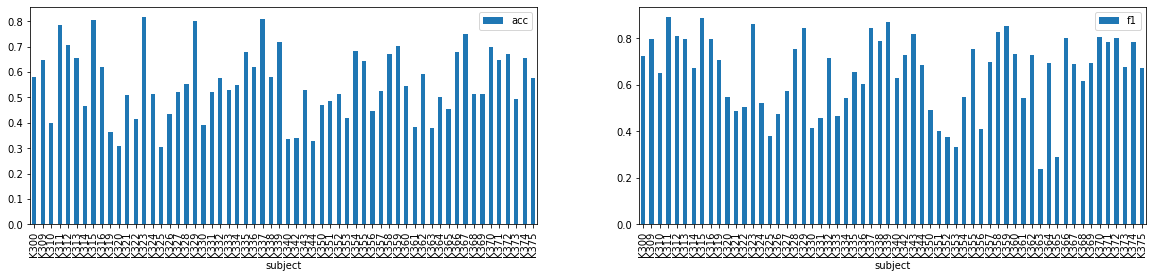

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
result.plot.bar(x="subject", y="acc", ax=axes[0])
result.plot.bar(x="subject", y="f1", ax=axes[1])

In [68]:
# intra-subject Cov-TangentSpace-LinearSVC - skip prefrontal & occipital
result = pd.DataFrame({
    "subject": test_subjects,
    "acc": test_acc,
    "f1": test_f1,
})
print(f"avg acc: {result['acc'].mean()}")
print(f"avg f1: {result['f1'].mean()}")

avg acc: 0.6079890219506354
avg f1: 0.7014710208709531


In [71]:
# intra-subject Cov-TangentSpace-LinearSVC - skip prefrontal & occipital & parietal
result = pd.DataFrame({
    "subject": test_subjects,
    "acc": test_acc,
    "f1": test_f1,
})
print(f"avg acc: {result['acc'].mean()}")
print(f"avg f1: {result['f1'].mean()}")

avg acc: 0.5903173576858592
avg f1: 0.688036506912291


In [74]:
# intra-subject Cov-TangentSpace-LinearSVC - skip prefrontal & occipital & frontal
result = pd.DataFrame({
    "subject": test_subjects,
    "acc": test_acc,
    "f1": test_f1,
})
print(f"avg acc: {result['acc'].mean()}")
print(f"avg f1: {result['f1'].mean()}")

avg acc: 0.5925574908825048
avg f1: 0.6866600763321963


In [77]:
# intra-subject Cov-TangentSpace-LinearSVC - skip prefrontal & occipital & frontal & parietal
result = pd.DataFrame({
    "subject": test_subjects,
    "acc": test_acc,
    "f1": test_f1,
})
print(f"avg acc: {result['acc'].mean()}")
print(f"avg f1: {result['f1'].mean()}")

avg acc: 0.5695073024196735
avg f1: 0.6729643592767108


In [80]:
# intra-subject Cov-TangentSpace-LinearSVC - skip prefrontal & occipital & frontal & parietal & temporal
result = pd.DataFrame({
    "subject": test_subjects,
    "acc": test_acc,
    "f1": test_f1,
})
print(f"avg acc: {result['acc'].mean()}")
print(f"avg f1: {result['f1'].mean()}")

avg acc: 0.5425820343330987
avg f1: 0.6522064615230193


In [83]:
# intra-subject Cov-TangentSpace-LinearSVC - frontal only
result = pd.DataFrame({
    "subject": test_subjects,
    "acc": test_acc,
    "f1": test_f1,
})
print(f"avg acc: {result['acc'].mean()}")
print(f"avg f1: {result['f1'].mean()}")

avg acc: 0.5227739631190804
avg f1: 0.6467795562809827


In [90]:
# intra-subject Cov-TangentSpace-LinearSVC - parietal only
result = pd.DataFrame({
    "subject": test_subjects,
    "acc": test_acc,
    "f1": test_f1,
})
print(f"avg acc: {result['acc'].mean()}")
print(f"avg f1: {result['f1'].mean()}")

avg acc: 0.5312208041176407
avg f1: 0.6396584903710456


In [93]:
# intra-subject Cov-TangentSpace-LinearSVC - FC & C & T & CP (13 chans)
result = pd.DataFrame({
    "subject": test_subjects,
    "acc": test_acc,
    "f1": test_f1,
})
print(f"avg acc: {result['acc'].mean()}")
print(f"avg f1: {result['f1'].mean()}")

avg acc: 0.5619951417971245
avg f1: 0.6647804591778119


In [18]:
# intra-subject Cov-TangentSpace-LinearSVC
result = pd.DataFrame({
    "subject": test_subjects,
    "acc": test_acc,
    "f1": test_f1,
})
print(f"avg acc: {result['acc'].mean()}")
print(f"avg f1: {result['f1'].mean()}")

avg acc: 0.623936318706582
avg f1: 0.7149484570665078


<AxesSubplot:xlabel='subject'>

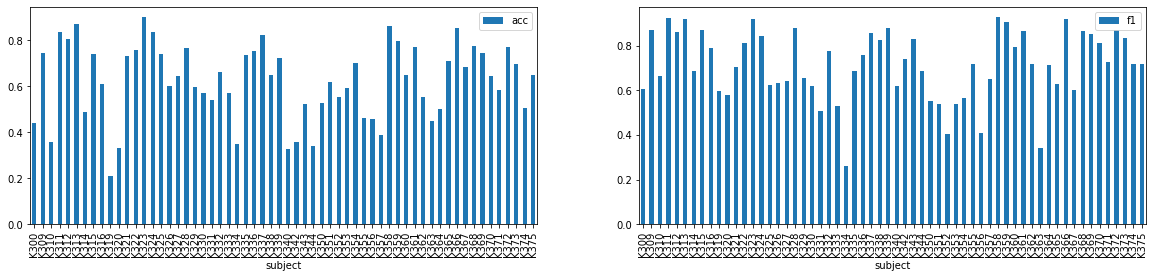

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
result.plot.bar(x="subject", y="acc", ax=axes[0])
result.plot.bar(x="subject", y="f1", ax=axes[1])

In [25]:
# LOSO - CSP(8)-LinearSVC
result = pd.DataFrame({
    "subject": test_subjects,
    "acc": test_acc,
    "f1": test_f1,
})
print(f"avg acc: {result['acc'].mean()}")
print(f"avg f1: {result['f1'].mean()}")

avg acc: 0.32944428062401143
avg f1: 0.5002810655854392


<AxesSubplot:xlabel='subject'>

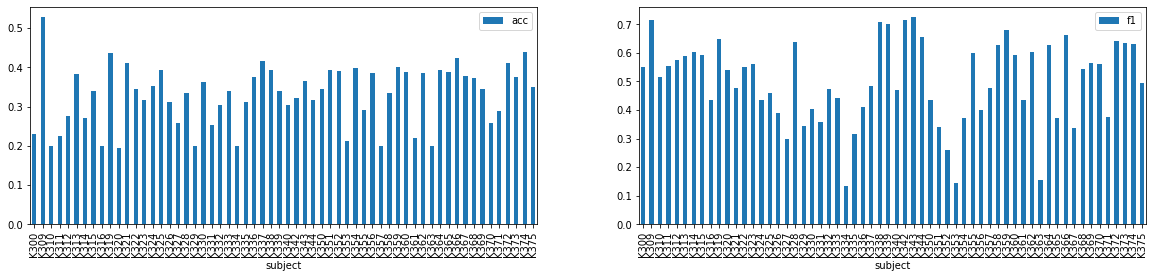

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
result.plot.bar(x="subject", y="acc", ax=axes[0])
result.plot.bar(x="subject", y="f1", ax=axes[1])

In [28]:
# LOSO - CSP(4)-LinearSVC
result = pd.DataFrame({
    "subject": test_subjects,
    "acc": test_acc,
    "f1": test_f1,
})
print(f"avg acc: {result['acc'].mean()}")
print(f"avg f1: {result['f1'].mean()}")

avg acc: 0.31576716670177984
avg f1: 0.4760743602325071


<AxesSubplot:xlabel='subject'>

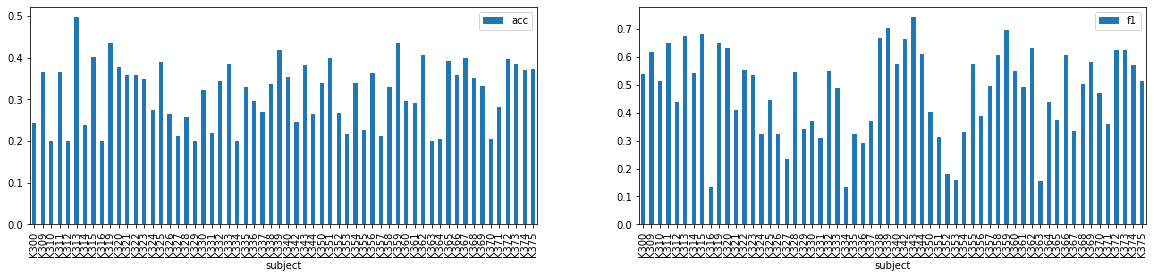

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
result.plot.bar(x="subject", y="acc", ax=axes[0])
result.plot.bar(x="subject", y="f1", ax=axes[1])

In [26]:
# Cov-TangentSpace-LinearSVM -> MI-ME
result = pd.DataFrame({
    "subject": test_subjects,
    "acc": test_acc,
    "f1": test_f1,
})
print(f"avg acc: {result['acc'].mean()}")
print(f"avg f1: {result['f1'].mean()}")

avg acc: 0.7046139274423082
avg f1: 0.7155401137364766


<AxesSubplot:xlabel='subject'>

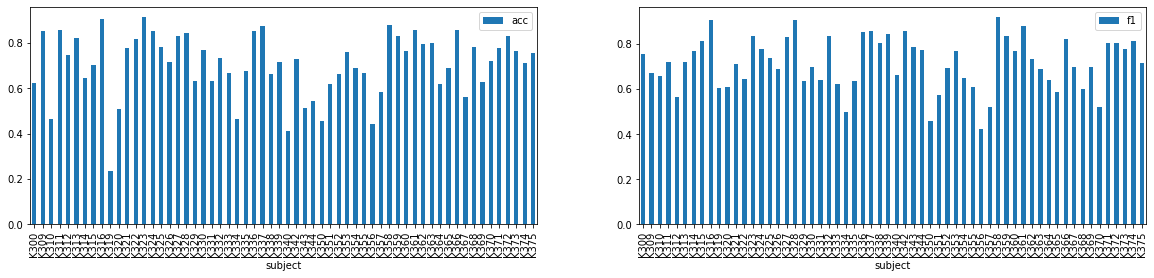

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
result.plot.bar(x="subject", y="acc", ax=axes[0])
result.plot.bar(x="subject", y="f1", ax=axes[1])

In [48]:
list_of_ds = list()
for i, r in ds_info[ds_info["subject"] == "K300"].iterrows():
    list_of_ds.append(ds.datasets[i])
    
subject_ds = BaseConcatDataset(list_of_ds)
subject_ds_info = subject_ds.description
subject_ds_info

,subject,scenario,event,label,trial,split
0,K300,nâng tay trái,Thinking,nâng tay trái,0,train
1,K300,nâng tay trái,Resting,rest,0,train
2,K300,nâng tay trái,Thinking and Acting,nâng tay trái,0,train
3,K300,nâng tay trái,Resting,rest,1,train
4,K300,nâng tay trái,Thinking,nâng tay trái,1,train
5,K300,nâng tay trái,Resting,rest,2,train
6,K300,nâng tay trái,Thinking and Acting,nâng tay trái,1,train
7,K300,nâng tay trái,Resting,rest,3,train
8,K300,nâng tay trái,Thinking,nâng tay trái,2,train
9,K300,nâng tay trái,Resting,rest,4,train


In [59]:
Xtrain = list()
Ytrain = list()
for i, r in ds_info[ds_info["subject"].isin([f"K{i}" for i in [375, 374, 373, 372, 371, 370]])].iterrows():
    x = ds.datasets[i].windows.get_data()
    y = ds.datasets[i].y
    Xtrain.append(x)
    Ytrain.extend(y)

Xtrain = np.concatenate(Xtrain, axis=0)
Ytrain = np.array(Ytrain, dtype=int)

In [60]:
np.bincount(Ytrain)

array([1028,  346,  335,  327,  336])

In [61]:
Ctrain = np.stack([np.cov(x, rowvar=True) for x in Xtrain])
Ctrain.shape

(2372, 32, 32)

In [62]:
channels

['Fp1',
 'Fp2',
 'F7',
 'F3',
 'Fz',
 'F4',
 'F8',
 'FT9',
 'FC5',
 'FC1',
 'FC2',
 'FC6',
 'FT10',
 'T7',
 'C3',
 'Cz',
 'C4',
 'T8',
 'CP5',
 'CP1',
 'CP2',
 'CP6',
 'P7',
 'P3',
 'Pz',
 'P4',
 'P8',
 'PO9',
 'O1',
 'Oz',
 'O2',
 'PO10']

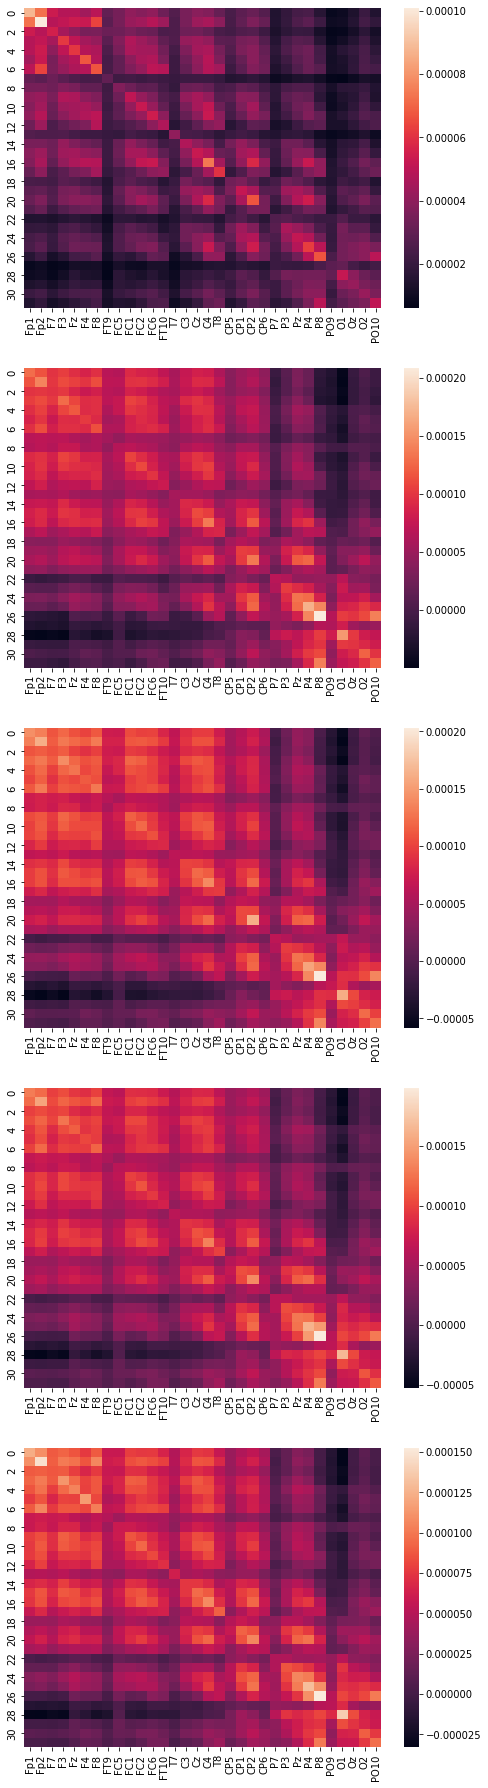

In [63]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 32))

for i in range(5):
    sb.heatmap(Ctrain[np.where(Ytrain == i)[0]].mean(axis=0), ax=axes[i])
    axes[i].set_xticklabels(channels)
    # axes[i].set_yticklabels(channels)